## Classifier: In Context Learing - K Demonstrators

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from utils.model import *

import numpy as np
import os
import time
import random
import torch

/root/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topics = ["cannabis", "energie", "kinder"]
models = [
    {
        "name": "aya-101",
        "model": "CohereForAI/aya-101",
        "tokenizer_class": "AutoTokenizer",
        "model_class": "AutoModelForSeq2SeqLM"
    },
    #{
    #    "name": "vicuna-13b",
    #    "model": "lmsys/vicuna-13b-v1.5",
    #    "tokenizer_class": "LlamaTokenizer",
    #    "model_class": "LlamaForCausalLM"
    #},
    # {
    #     "name": "vicuna-7b",
    #     "model": "lmsys/vicuna-7b-v1.5",
    #     "tokenizer_class": "LlamaTokenizer",
    #     "model_class": "LlamaForCausalLM"
    # },
    # {
    #     "name": "FLAN-t5-base",
    #     "model": "google/flan-t5-base",
    #     "tokenizer_class": "AutoTokenizer",
    #     "model_class": "AutoModelForSeq2SeqLM"
    # },
    # {
    #     "name": "FLAN-t5-large",
    #     "model": "google/flan-t5-large",
    #     "tokenizer_class": "AutoTokenizer",
    #     "model_class": "AutoModelForSeq2SeqLM"
    # },
    # {
    #     "name": "FLAN-t5-xxl",
    #     "model": "google/flan-t5-xxl",
    #     "tokenizer_class": "AutoTokenizer",
    #     "model_class": "AutoModelForSeq2SeqLM"
    # },
    # {
    #     "name": "leo-hessianai-13b",
    #     "model": "LeoLM/leo-hessianai-13b",
    #     "tokenizer_class": "AutoTokenizer",
    #     "model_class": "AutoModelForCausalLM"
    # },
    # {
    #     "name": "leo-hessianai-7b",
    #     "model": "LeoLM/leo-hessianai-7b",
    #     "tokenizer_class": "AutoTokenizer",
    #     "model_class": "AutoModelForCausalLM"
    # },

]

## Curated Examples

In [3]:
curated_examples = {
    "cannabis": {
        "positive_examples": [
            {
                "text": "Krieg sowie die Corona-Pandemie. Hinzu kommt die Bürokratie: In Deutschland braucht es im Schnitt rund 175 Tage, bis der komplette Gesetzgebungsprozess durchlaufen ist und ein Gesetz in Kraft tritt. Einige Experten halten Anfang 2024 für das früheste realistische Datum der Legalisierung. Lobbyisten gehen von einer Gesetzesänderung nicht vor dem vierten Quartal 2024 aus. Finanzminister Christian Lindner (FPD) hatte indes eine Einführung im Jahr 2023 in Aussicht gestellt. Wer wird Recht behalten? Auch innerhalb der Regierungskoalition wächst der Druck auf Gesundheitsminister Karl Lauterbach (SPD). Die für das Gesundheitsministerium zuständigen Haushaltspolitiker wollen Lauterbach zur raschen Umsetzung der Cannabis-Legalisierung bewegen - mit einem ungewöhnlichen Mittel: Durch Beschluss des Haushaltsausschusses sei ein Betrag von einer Million Euro für die Öffentlichkeitsarbeit des Ministeriums so lange gesperrt, bis das im Koalitionsvertrag vereinbarte Cannabiskontrollgesetz vorgelegt werde. Das sagte die Grünen-Bundestagsabgeordnete Paula Piechotta gegenüber RND ",
                "label": 1
            },
            {
                "text": "Die geplante Cannabis-Legalisierung in Deutschland könnte weitreichende positive Auswirkungen auf die Wirtschaft und das Gesundheitswesen haben. Experten prognostizieren eine signifikante Steigerung der Steuereinnahmen, ähnlich den Erfahrungen in Kanada und einigen US-Bundesstaaten, wo Cannabis bereits legalisiert wurde. Darüber hinaus erwarten Gesundheitsexperten eine Verbesserung in der Qualität und Sicherheit von Cannabisprodukten, da diese durch staatliche Stellen reguliert und überwacht werden. Dies könnte nicht nur den Schwarzmarkt eindämmen, sondern auch den Verbraucherschutz stärken. Zudem wird eine Entlastung der Justiz und Polizei vorhergesagt, da die Ressourcen, die bisher für die Verfolgung von Cannabis-Delikten aufgewendet wurden, nun für die Bekämpfung schwerwiegenderer Kriminalität eingesetzt werden können. Wirtschaftsanalysten sehen in der Legalisierung zudem das Potential für die Schaffung neuer Arbeitsplätze in Landwirtschaft, Einzelhandel und im Bereich der medizinischen Forschung. Die politische Debatte gewinnt an Fahrt, und viele Bürgerinnen und Bürger setzen hohe Erwartungen in die geplanten Reformen.",
                "label": 1
            }
        ],
        "negative_examples": [
            {
                "text": "News Ratgeber Reise Reise Völlig daneben: Wenn Touristen die Benimmregeln missachten Aktualisiert am 27.06.2023, 16:26 Uhr Das Foto des Bergsteigers Dawa Steven Sherpa zeigt das vierte Lager, das höchste am Mount Everest, das mit verlassenen Zelten übersät ist. © picture alliance/dpa/Dawa Steven Sherpa/Asian Trekking Lesedauer: 5 Min. Teilen Artikel teilen Urlauberinnen und Urlauber benehmen sich manchmal völlig daneben. Alkoholexzesse, Pöbeleien und Vermüllung sind nur einige der Dinge, mit denen sich Einheimische herumschlagen müssen. Jedes Land zieht jedoch eigene Konsequenzen aus dem Verhalten der Touristinnen und Touristen. Mehr zum Thema Reise Die indonesische Urlaubsinsel Bali machte zuletzt wochenlang Schlagzeilen - nicht mit Tempeltänzen und Traumstränden, sondern mit ungenierten Touristen.",
                "label": 0
            },
            {
                "text": "Die Bundesregierung hat sich das Ziel gesetzt, bis 2045 klimaneutral zu sein. Dafür müssen die Treibhausgasemissionen um 65 Prozent gegenüber 1990 reduziert werden. Ein wichtiger Baustein ist die Energiewende. Sie soll dazu beitragen, dass Deutschland bis 2035 zu 100 Prozent aus erneuerbaren Energien versorgt wird. Dafür müssen die erneuerbaren Energien ausgebaut und die fossilen Energieträger reduziert werden. Die Energiewende ist ein Mammutprojekt, das viele Herausforderungen mit sich bringt. Dazu gehören der Ausbau der Stromnetze, die Speicherung von Energie und die Sektorenkopplung. Die Energiewende ist ein wichtiger Schritt, um den Klimawandel zu bekämpfen und die Umwelt zu schützen.",
                "label": 0
            }
        ],
    },
    "energie": {
        "positive_examples": [
            {
                "text": "Die Bundesregierung hat sich das Ziel gesetzt, bis 2045 klimaneutral zu sein. Dafür müssen die Treibhausgasemissionen um 65 Prozent gegenüber 1990 reduziert werden. Ein wichtiger Baustein ist die Energiewende. Sie soll dazu beitragen, dass Deutschland bis 2035 zu 100 Prozent aus erneuerbaren Energien versorgt wird. Dafür müssen die erneuerbaren Energien ausgebaut und die fossilen Energieträger reduziert werden. Die Energiewende ist ein Mammutprojekt, das viele Herausforderungen mit sich bringt. Dazu gehören der Ausbau der Stromnetze, die Speicherung von Energie und die Sektorenkopplung. Die Energiewende ist ein wichtiger Schritt, um den Klimawandel zu bekämpfen und die Umwelt zu schützen.",
                "label": 1
            },
            {
                "text": "In einem beispiellosen Schritt zur Förderung der Nachhaltigkeit und zur Bekämpfung des Klimawandels hat die Bundesregierung umfangreiche Investitionen in grüne Technologien angekündigt. Ziel ist es, die Abhängigkeit von fossilen Brennstoffen zu verringern und den Übergang zu einer grünen Wirtschaft zu beschleunigen. Besonderes Augenmerk liegt auf der Wind- und Solarenergie, deren Kapazitäten bis zum Jahr 2030 verdoppelt werden sollen. Darüber hinaus werden innovative Projekte im Bereich der Wasserstofftechnologie und der Elektromobilität gefördert, um die CO2-Emissionen im Verkehrssektor zu senken. Diese Maßnahmen sind Teil des umfassenden Plans der Bundesregierung, Deutschland bis 2045 zum ersten klimaneutralen Industrieland zu machen. Durch diese Vorreiterrolle im Bereich der erneuerbaren Energien setzt Deutschland nicht nur ein starkes internationales Zeichen im Kampf gegen den Klimawandel, sondern schafft auch zukunftssichere Arbeitsplätze und fördert die wirtschaftliche Innovation.",
                "label": 1
            }
        ],
        "negative_examples": [
            {
                "text": "News Ratgeber Reise Reise Völlig daneben: Wenn Touristen die Benimmregeln missachten Aktualisiert am 27.06.2023, 16:26 Uhr Das Foto des Bergsteigers Dawa Steven Sherpa zeigt das vierte Lager, das höchste am Mount Everest, das mit verlassenen Zelten übersät ist. © picture alliance/dpa/Dawa Steven Sherpa/Asian Trekking Lesedauer: 5 Min. Teilen Artikel teilen Urlauberinnen und Urlauber benehmen sich manchmal völlig daneben. Alkoholexzesse, Pöbeleien und Vermüllung sind nur einige der Dinge, mit denen sich Einheimische herumschlagen müssen. Jedes Land zieht jedoch eigene Konsequenzen aus dem Verhalten der Touristinnen und Touristen. Mehr zum Thema Reise Die indonesische Urlaubsinsel Bali machte zuletzt wochenlang Schlagzeilen - nicht mit Tempeltänzen und Traumstränden, sondern mit ungenierten Touristen.",
                "label": 0
            },
            {
                "text": "Krieg sowie die Corona-Pandemie. Hinzu kommt die Bürokratie: In Deutschland braucht es im Schnitt rund 175 Tage, bis der komplette Gesetzgebungsprozess durchlaufen ist und ein Gesetz in Kraft tritt. Einige Experten halten Anfang 2024 für das früheste realistische Datum der Legalisierung. Lobbyisten gehen von einer Gesetzesänderung nicht vor dem vierten Quartal 2024 aus. Finanzminister Christian Lindner (FPD) hatte indes eine Einführung im Jahr 2023 in Aussicht gestellt. Wer wird Recht behalten? Auch innerhalb der Regierungskoalition wächst der Druck auf Gesundheitsminister Karl Lauterbach (SPD). Die für das Gesundheitsministerium zuständigen Haushaltspolitiker wollen Lauterbach zur raschen Umsetzung der Cannabis-Legalisierung bewegen - mit einem ungewöhnlichen Mittel: Durch Beschluss des Haushaltsausschusses sei ein Betrag von einer Million Euro für die Öffentlichkeitsarbeit des Ministeriums so lange gesperrt, bis das im Koalitionsvertrag vereinbarte Cannabiskontrollgesetz vorgelegt werde. Das sagte die Grünen-Bundestagsabgeordnete Paula Piechotta gegenüber RND ",
                "label": 1
            }
        ],
    },
    "kinder": {
        "positive_examples": [
            {
                "text": "Jedes fünfte Kind in Deutschland gilt als arm. Eine der dringendsten Aufgaben der Politik ist es deshalb, Armutsrisiken zu verringern und gleiche Entwicklungs- und Teilhabechance für Kinder und Jugendliche zu schaffen. Rund 70 Prozent der Bevölkerung unterstützen nach einer aktuellen Umfrage des Instituts für Demoskopie Allensbach (IfD Allensbach) die Bekämpfung von Kinderarmut. Mehr als 65 Prozent wünschen sich, dass mehr für die Chancengerechtigkeit von Kindern unabhängig von der sozialen Herkunft getan wird. Auftrag aus dem Koalitionsvertrag Im Koalitionsvertrag ist der Auftrag zur Einführung einer Kindergrundsicherung verankert. Dieser gibt den Rahmen vor, um die Kindergrundsicherung auszugestalten. Im Koalitionsvertrag heißt es: Jedes Kind soll die gleichen Chancen haben. Diese Chancengleichheit ist aber noch lange nicht Realität. Wir wollen mehr Kinder aus der Armut holen, werden mit der Kindergrundsicherung bessere Chancen für Kinder und Jugendliche schaffen und konzentrieren uns auf die, die am meisten Unterstützung brauchen. Was soll die Kindergrundsicherung erreichen?",
                "label": 1
            },
            {
                "text": "In einem bemerkenswerten Schritt zur Verbesserung der Lebensqualität und Zukunftschancen von Kindern in Deutschland hat die Bundesregierung die Einführung eines nationalen Aktionsplans gegen Kinderarmut beschlossen. Dieser Aktionsplan zielt darauf ab, Kindern unabhängig von ihrer sozialen und wirtschaftlichen Herkunft gleiche Chancen zu bieten. Er umfasst Maßnahmen wie verbesserten Zugang zu Bildung und Gesundheitsversorgung, kostenlose Mahlzeiten in Schulen und Kitas, sowie verstärkte finanzielle Unterstützung für Familien mit niedrigem Einkommen. Darüber hinaus wird ein besonderer Fokus auf die Förderung von Kindern in benachteiligten Regionen gelegt, um regionale Disparitäten zu verringern. Der Aktionsplan genießt breite Unterstützung in der Bevölkerung und wird als entscheidender Schritt gesehen, um die Kinderarmut in Deutschland signifikant zu reduzieren und allen Kindern eine gerechte Chance auf eine erfolgreiche Zukunft zu ermöglichen.",
                "label": 1
            }
        ],
        "negative_examples": [
            {
                "text": "News Ratgeber Reise Reise Völlig daneben: Wenn Touristen die Benimmregeln missachten Aktualisiert am 27.06.2023, 16:26 Uhr Das Foto des Bergsteigers Dawa Steven Sherpa zeigt das vierte Lager, das höchste am Mount Everest, das mit verlassenen Zelten übersät ist. © picture alliance/dpa/Dawa Steven Sherpa/Asian Trekking Lesedauer: 5 Min. Teilen Artikel teilen Urlauberinnen und Urlauber benehmen sich manchmal völlig daneben. Alkoholexzesse, Pöbeleien und Vermüllung sind nur einige der Dinge, mit denen sich Einheimische herumschlagen müssen. Jedes Land zieht jedoch eigene Konsequenzen aus dem Verhalten der Touristinnen und Touristen. Mehr zum Thema Reise Die indonesische Urlaubsinsel Bali machte zuletzt wochenlang Schlagzeilen - nicht mit Tempeltänzen und Traumstränden, sondern mit ungenierten Touristen.",
                "label": 0
            },
            {
                "text": "Die Bundesregierung hat sich das Ziel gesetzt, bis 2045 klimaneutral zu sein. Dafür müssen die Treibhausgasemissionen um 65 Prozent gegenüber 1990 reduziert werden. Ein wichtiger Baustein ist die Energiewende. Sie soll dazu beitragen, dass Deutschland bis 2035 zu 100 Prozent aus erneuerbaren Energien versorgt wird. Dafür müssen die erneuerbaren Energien ausgebaut und die fossilen Energieträger reduziert werden. Die Energiewende ist ein Mammutprojekt, das viele Herausforderungen mit sich bringt. Dazu gehören der Ausbau der Stromnetze, die Speicherung von Energie und die Sektorenkopplung. Die Energiewende ist ein wichtiger Schritt, um den Klimawandel zu bekämpfen und die Umwelt zu schützen.",
                "label": 1
            }
        ],
    }
}

## Define Prompt Template:

In [4]:
PROMPT_TEMPLATE_FEW_SHOT = """Classify the following webpage text in {lang} as topic releated or unrelated. Does it contain information about '{topic}'? Please answer with 'Yes' or 'No' only.

Examples:
{examples}

Text: '''{webpage_text}'''
Answer:"""

PROMPT_TEMPLATE_EXAMPLES = """
Example: '''{text}'''
Answer: '{label}'
"""


# Example text
example_list = [
    {
        "text": "Cannabis ist eine Droge.",
        "label": "Yes"
    },
    {
        "text": "Katzen sind Tiere.",
        "label": "No"
    }
]

example_prompt_list = [PROMPT_TEMPLATE_EXAMPLES.format(text=example["text"], label=example["label"]) for example in example_list]

# print("Example prompt list:")
# print("\n".join(example_prompt_list))

# Test the template with a dummy text
prompt_test = PROMPT_TEMPLATE_FEW_SHOT.format(topic = "Cannabis", lang = 'German', webpage_text='Lorem ipsum dolor sit amet, consectetur adipiscing elit.', examples="".join(example_prompt_list))
print(prompt_test)

Classify the following webpage text in German as topic releated or unrelated. Does it contain information about 'Cannabis'? Please answer with 'Yes' or 'No' only.

Examples:

Example: '''Cannabis ist eine Droge.'''
Answer: 'Yes'

Example: '''Katzen sind Tiere.'''
Answer: 'No'


Text: '''Lorem ipsum dolor sit amet, consectetur adipiscing elit.'''
Answer:


## Define Parameter for Text Generation

Each parameter influences the text generation in a specific way. Below are the parameters along with a brief explanation:

**`max_length`**:
* Sets the maximum number of tokens in the generated text (default is 50).
* Generation stops if the maximum length is reached before the model produces an EOS token.
* A higher `max_length` allows for longer generated texts but may increase the time and computational resources required.

**`min_length`**:
* Sets the minimum number of tokens in the generated text (default is 10).
* Generation continues until this minimum length is reached even if an EOS token is produced.

**`num_beams`**:
* In beam search, sets the number of "beams" or hypotheses to keep at each step (default is 4).
* A higher number of beams increases the chances of finding a good output but also increases the computational cost.

**`num_return_sequences`**:
* Specifies the number of independently computed sequences to return (default is 3).
* When using sampling, multiple different sequences are generated independently from each other.

**`early_stopping`**:
* Stops generation if the model produces the EOS (End Of Sentence) token, even if the predefined maximum length is not reached (default is True).
* Useful when an EOS token signifies the logical end of a text (often represented as `</s>`).

**`do_sample`**:
* Tokens are selected probabilistically based on their likelihood scores (default is True).
* Introduces randomness into the generation process for diverse outputs.
* The level of randomness is controlled by the 'temperature' parameter.

**`temperature`**:
* Adjusts the probability distribution used for sampling the next token (default is 0.7).
* Higher values make the generation more random, while lower values make it more deterministic.

**`top_k`**:
* Limits the number of tokens considered for sampling at each step to the top K most likely tokens (default is 50).
* Can make the generation process faster and more focused.

**`top_p`**:
* Also known as nucleus sampling, sets a cumulative probability threshold (default is 0.95).
* Tokens are sampled only from the smallest set whose cumulative probability exceeds this threshold.

**`repetition_penalty`**:
* Discourages the model from repeating the same token by modifying the token's score (default is 1.5).
* Values greater than 1.0 penalize repetitions, and values less than 1.0 encourage repetitions.


In [5]:
params = {'do_sample': True,
          'early_stopping': True,
          'num_beams': 5,
          'num_return_sequences': 5,
          'max_new_tokens': 1024,
          'min_new_tokens': 1,
          'output_scores': True,
          # 'repetition_penalty': 1.0,
          'temperature': 0.6,
          'top_k': 50,
          'top_p': 1.0
          }

## Helper Functions

In [6]:
def compile_prompt(article, template, template_example, topic, examples, lang='German'):
    """ Compiles the prompt for the given article and model."""

    # Get the text of the article
    article_text = article.get("text")
    example_prompts = [template_example.format(text=example["text"], label= "Yes" if example["label"] == 1 else "No") for example in examples]
    prompt = template.format(topic = topic, lang = lang, webpage_text=article_text, examples="".join(example_prompts))

    return prompt

In [7]:
def calculate_input_length(prompt):
    """ Calculates the length of the input sequence for the model. """

    # Tokenize the prompt
    tokenized_prompt = tokenizer(
        prompt, return_tensors="pt", add_special_tokens=False, truncation=False, padding=False)

    # Calculate the length of the input sequence
    input_length = tokenized_prompt.input_ids.size(1)

    return input_length

In [8]:
def generate_answers(model, tokenizer, prompt, params, remove_input=True):
    """Generates answers from a language model for a given prompt."""

    # Encode the prompt and generate the answers
    encoded_input = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    if encoded_input.size()[1] > tokenizer.model_max_length:
        print("Input too long, truncating.")
        # encoded_input = encoded_input[:, :tokenizer.model_max_length]

    generated_outputs = model.generate(encoded_input, **params)

    # Decode and clean outputs
    outputs = []
    input_text_wo_st = tokenizer.decode(
        encoded_input[0], skip_special_tokens=True)
    for output in generated_outputs:
        decoded_text = tokenizer.decode(output, skip_special_tokens=True)
        cleaned_text = decoded_text.replace(input_text_wo_st, "").strip()
        outputs.append(cleaned_text if remove_input else decoded_text)

    return outputs

In [9]:
def parse_response(output_text):
    """Determines if the model's output signifies "Yes" (1) or "No" (0)."""
    text = output_text.lower()
    return 1 if "yes" in text else 0 if "no" in text else 0


In [10]:
def calc_metrics(labels, preds):
    """
    Calculates the accuracy, precision, recall, and F1 score for the given labels and predictions and returns them in a dictionary.
    """

    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1': f1_score(labels, preds, average='binary'),
    }

    return metrics

In [11]:
def sample_random_from_dataset(dataset, n=5, subset='test'):
    """
    Samples n random examples from a specified subset of the dataset.
    """
    n = min(n, len(dataset[subset]))
    random_indices = random.sample(range(len(dataset[subset])), n)
    sampled_dataset = dataset[subset].select(random_indices)
    return sampled_dataset


In [12]:
def load_model_and_tokenizer(model_details):
    """
    Loads a model and its corresponding tokenizer based on the provided model details.
    """
    model_name = model_details['model']
    tokenizer_class = model_details['tokenizer_class']
    model_class = model_details['model_class']
    
    # Cohere models and FLAN models
    if tokenizer_class == "AutoTokenizer" and model_class == "AutoModelForSeq2SeqLM":
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name, device_map="auto", load_in_8bit=True)
        
    # Vicuna models
    elif tokenizer_class == "LlamaTokenizer" and model_class == "LlamaForCausalLM":
        from transformers import LlamaTokenizer, LlamaForCausalLM
        tokenizer = LlamaTokenizer.from_pretrained(model_name)
        model = LlamaForCausalLM.from_pretrained(model_name, device_map="auto", load_in_8bit=True)
        
    #  LeoLM models  
    elif tokenizer_class == "AutoTokenizer" and model_class == "AutoModelForCausalLM":
        from transformers import AutoTokenizer, AutoModelForCausalLM
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto", load_in_8bit=True)
        
    else:
        raise ValueError("Model class not supported.")
        
    return tokenizer, model


**Different Sample Methods**

In [13]:
from random import sample


################### Random Sampling ############################

def sample_examples_random(dataset, k=2):
    """Samples k pairs of examples completely at random."""
    dataset_sampled = dataset.shuffle().select(range(k))
    return [example for example in dataset_sampled]


################### Random Sampling balanced ###################

def sample_examples_random_balanced(dataset, k=2):
    """Samples k pairs of examples, each pair containing one positive and one negative example."""
    # Separate the dataset into positive and negative examples
    positive_examples = [example for example in dataset if example['label'] == 1]
    negative_examples = [example for example in dataset if example['label'] == 0]
    
    # Sample k examples from each subset
    sampled_positive = sample(positive_examples, k)
    sampled_negative = sample(negative_examples, k)
    
    # Alternate between positive and negative examples to create pairs
    examples = []
    for idx in range(k):
        if idx % 2 == 0:
            examples.append(sampled_positive[idx])
        else:
            examples.append(sampled_negative[idx])
    
    return examples


################### KNN Sampling ############################

def sample_examples_knn(model, index, query, dataset, k=2):
    inferred_vector = model.encode(query, convert_to_tensor=True, show_progress_bar = False)
    sims = index.get_nns_by_vector(inferred_vector, k, search_k=-1, include_distances=False)
    return [dataset[idx] for idx in sims]

################### Expert Sampling ############################

def sample_from_expert(curated_examples, topic, k=2):
    
    curated_examples_topic = curated_examples[topic]
    sampled_positive = sample(curated_examples_topic['positive_examples'], k)
    sampled_negative = sample(curated_examples_topic['negative_examples'], k)
    
    # Alternate between positive and negative examples to create pairs
    examples = []
    for idx in range(k):
        if idx % 2 == 0:
            examples.append(sampled_positive[idx])
        else:
            examples.append(sampled_negative[idx])
    
    return examples


**Create Index:**

In [14]:
from annoy import AnnoyIndex

In [15]:
# Load the transformer-based model
from sentence_transformers import SentenceTransformer, util
encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [16]:
# Function to encode texts to embeddings
def encode_to_embedding(example):
    example['embeddings'] = encoder.encode(example['text'])
    return example

# # Apply the function to the dataset
# dataset = dataset.map(encode_to_embedding, batched=True)
# print("Sentence embedding dimension", encoder.get_sentence_embedding_dimension())

In [17]:
from collections import Counter

def majority_voting(answers):
    """Apply majority voting to a list of arbitrary classification answers."""
    count = Counter(answers)
    most_common = count.most_common(2)  # Get the two most common answers
    
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return "Tie"
    return most_common[0][0]

# Example usage with arbitrary labels
answers = ["Apple", "Banana", "Apple", "Orange"]
print(f"The majority vote is: {majority_voting(answers)}")

The majority vote is: Apple


## Generate Answers

In [18]:
from collections import defaultdict
import gc

In [19]:
# dataset = load_from_disk(f"../data/tmp/processed_dataset_cannabis_buffed_chunkified_random_496")
# dataset['test'] = sample_random_from_dataset(dataset, n=10, subset='test')
# tmp = dataset['test'].filter(lambda x: x['token_count'] > 200)
# tmp[1]

**Load Model:**

In [20]:
model_details = models[0]

# Load model
model_name = model_details['model']
print(f"Loading model {model_name}")

# Load model and tokenizer
tokenizer, model = load_model_and_tokenizer(model_details)

Loading model CohereForAI/aya-101


Loading checkpoint shards: 100%|█████████████████████████████████████████████████| 11/11 [04:52<00:00, 26.62s/it]


**Evaluate for different values of k:**

In [34]:
eval_results = defaultdict(dict)
topics = ["cannabis", "energie", "kinder"]
chunk_length = 192
#ks = [0, 1, 2, 3, 4] #, 8, 16]
ks = [0, 1, 2, 4, 8, 16] #, 8, 16]

for topic in topics:  # ----------------------------------------------------------------------

    # Load dataset
    print(f"Loading dataset for {topic}")
    dataset = load_from_disk(f"../data/tmp/processed_dataset_{topic}_buffed_chunkified_random_{chunk_length}")
    #dataset['test'] = dataset['test'].filter(lambda x: x['token_count'] > 200)
    #dataset['test'] = sample_random_from_dataset(dataset, n=50, subset='test')
    #article_index = AnnoyIndex(encoder.get_sentence_embedding_dimension(), "angular")
    #article_index.load(f'../data/indices/page_index_{topic}.ann')

    for k in ks:
        examples = sample_examples_random_balanced(dataset['train'], k) 
        # examples = sample_examples_random(dataset['train'], k) 
        # examples = sample_examples_knn(dataset['train'], k)
        # examples = sample_from_expert(curated_examples, topic, k)

        # Generate answers
        answers = [] 
        for row in tqdm(dataset['test']): # ---------------------------------------------------
            #examples_knn = sample_examples_knn(encoder, article_index, row["text"], dataset["train"], k)
            prompt = compile_prompt(row, PROMPT_TEMPLATE_FEW_SHOT, PROMPT_TEMPLATE_EXAMPLES, topic, examples)
            answers.append(generate_answers(model, tokenizer, prompt, params))
    
        # Add answers to the dataset
        if "answers" in dataset['test'].column_names:
            dataset['test'] = dataset['test'].map(lambda example, idx: {"answers": answers[idx]}, with_indices=True)
        else:
            dataset['test'] = dataset['test'].add_column("answers", answers)
        dataset.save_to_disk(f"../data/tmp/processed_dataset_{topic}_answers_fs_k_{k}")
        
        # Calculate metrics
        answers_after_voting = [majority_voting(ans) for ans in answers]
        answers_parsed = [parse_response(ans) for ans in answers_after_voting]
        print(answers_parsed)
        metrics = calc_metrics(dataset['test']['label'], answers_parsed)
        eval_results[topic][k] = metrics
        print(f"Metrics for k = {k}: {metrics}")

Loading dataset for cannabis


Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 148472.04 examples/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 156618.51 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 150608.13 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 155711.99 examples/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 163314.88 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1193/1193 [00:00<00:00, 162376.84 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 156891.59 examples/s]


[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 162951.89 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 165853.33 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 166752.73 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 165080.95 examples/s]


[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|████████████████████████████| 1217/1217 [00:00<00:00, 162879.10 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 145566.59 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 152069.65 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 146827.55 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 151437.85 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 148983.81 examples/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Saving the dataset (1/1 shards): 100%|██████████████████████████████| 982/982 [00:00<00:00, 150883.09 examples/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [35]:
dataset['test'][0]

{'_id': '64a0946e749484eec8576914',
 'batch_id': 16,
 'domain': 'n-tv.de',
 'view_url': 'n-tv.de/panorama/Papst-schickt-beurlaubten-Gaenswein-nach-Freiburg-article24193350.html',
 'lang': 'de',
 'text': 'Sonntag, 02. Juli 2023 01:40 Uhr Frankfurt | 00:40 Uhr London | 19:40 Uhr New York | 08:40 Uhr Tokio Ressorts Das Beste Bilderserien Politik Meldungen Kommentare Pressestimmen Person der Woche Wieduwilts Woche Wirtschaft Meldungen Termine Startup Börse Auf einen Blick Aktien & Indizes Dax TecDax MDax SDax Gex HDax EuroStoxx50 Stoxx50 Dow Jones Nasdaq Nikkei Devisen Rohstoffe ntv Zertifikate ntv Fonds Fonds & ETF Anleihen ntv Altersvorsorge ntv Geldanlage-Check Börsen-Tag - Archiv Sport Live-Kalender Meldungen Kolumnen Collinas Erben Redelings Nachspielzeit Fußball-Zeitreise Fußball Kolumnen Testländerspiele WM 2023 Bundesliga 2. Bundesliga 3',
 'text_length': 649,
 'word_count': 91,
 'topic': 'kinder',
 'category': 'news',
 'good_for_training': 'True',
 'good_for_augmentation': 'True',

Accuracy: 0.834
Accuracy: 0.94

In [36]:
print(eval_results)

defaultdict(<class 'dict'>, {'cannabis': {0: {'accuracy': 0.7141659681475272, 'precision': 1.0, 'recall': 0.5721455457967378, 'f1': 0.727853152434158}, 1: {'accuracy': 0.6429170159262364, 'precision': 0.9973190348525469, 'recall': 0.46675031367628605, 'f1': 0.6358974358974359}, 2: {'accuracy': 0.636211232187762, 'precision': 0.9945504087193461, 'recall': 0.45796737766624845, 'f1': 0.627147766323024}, 4: {'accuracy': 0.7267393126571668, 'precision': 0.9978858350951374, 'recall': 0.5922208281053952, 'f1': 0.7433070866141732}, 8: {'accuracy': 0.7242246437552389, 'precision': 0.9193548387096774, 'recall': 0.64366373902133, 'f1': 0.7571955719557195}, 16: {'accuracy': 0.7351215423302598, 'precision': 0.9563567362428842, 'recall': 0.6323713927227101, 'f1': 0.7613293051359517}}, 'energie': {0: {'accuracy': 0.6647493837304848, 'precision': 0.9411764705882353, 'recall': 0.13675213675213677, 'f1': 0.23880597014925373}, 1: {'accuracy': 0.7033689400164339, 'precision': 0.9652173913043478, 'recall':

## Save and Output Results

In [37]:
from tabulate import tabulate

In [38]:
# Define the file path to save the dictionary
file_path = "eval_results_icl_few_shot_evaluate_K.json"

In [39]:
import json

# Save the dictionary to disk as JSON
with open(file_path, "w") as file:
    json.dump(eval_results, file)

In [40]:
import json

# Load the dictionary from the JSON file
with open(file_path, "r") as file:
    eval_results = json.load(file)

In [41]:
# Identify all topics (assuming all models are evaluated on the same topics)
topics = list(next(iter(eval_results.values())).keys())

# Prepare headers for the table: each topic will have four metrics
headers = ["Model"] + \
    [f"{topic} {metric}" for topic in topics for metric in [
        "Acc.", "Prec.", "Rec.", "F1"]]

# Prepare rows: one row per model, containing metrics for each topic
rows = []
for model_name, topics_metrics in eval_results.items():
    row = [model_name]  # Start with the model name
    for topic in topics:
        metrics = topics_metrics.get(topic, {})
        row.extend([metrics.get('accuracy', 0.0), metrics.get(
            'precision', 0.0), metrics.get('recall', 0.0), metrics.get('f1', 0.0)])
    rows.append(row)

# Generate the HTML table
table_html = tabulate(rows, headers=headers, tablefmt="html",
                      showindex="never", floatfmt=".3f")

In [42]:
from IPython.display import display, HTML
display(HTML(table_html))

Model,0 Acc.,0 Prec.,0 Rec.,0 F1,1 Acc.,1 Prec.,1 Rec.,1 F1,2 Acc.,2 Prec.,2 Rec.,2 F1,4 Acc.,4 Prec.,4 Rec.,4 F1,8 Acc.,8 Prec.,8 Rec.,8 F1,16 Acc.,16 Prec.,16 Rec.,16 F1
cannabis,0.714,1.000,0.572,0.728,0.643,0.997,0.467,0.636,0.636,0.995,0.458,0.627,0.727,0.998,0.592,0.743,0.724,0.919,0.644,0.757,0.735,0.956,0.632,0.761
energie,0.665,0.941,0.137,0.239,0.703,0.965,0.237,0.381,0.659,0.908,0.126,0.221,0.675,0.974,0.160,0.275,0.756,0.775,0.515,0.619,0.676,0.885,0.182,0.301
kinder,0.631,0.868,0.085,0.154,0.709,0.991,0.269,0.423,0.711,1.000,0.272,0.427,0.772,0.994,0.428,0.599,0.765,0.880,0.472,0.614,0.789,0.930,0.508,0.657


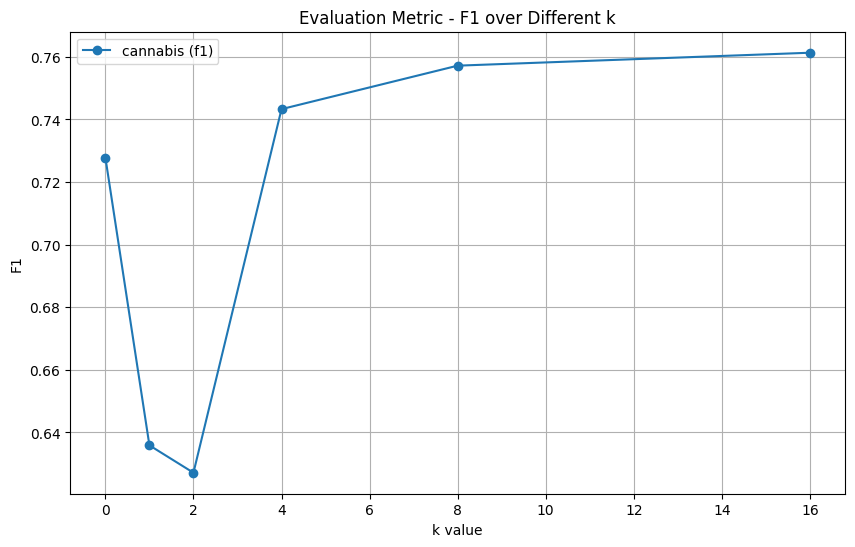

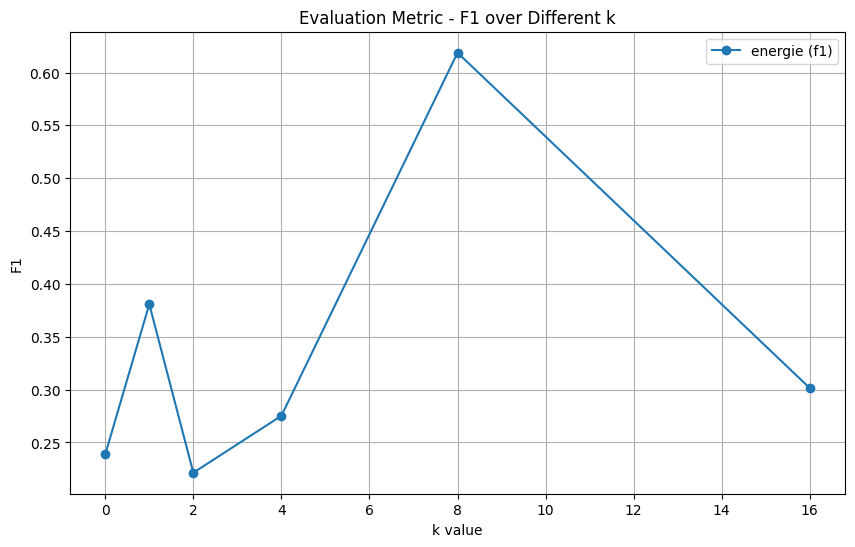

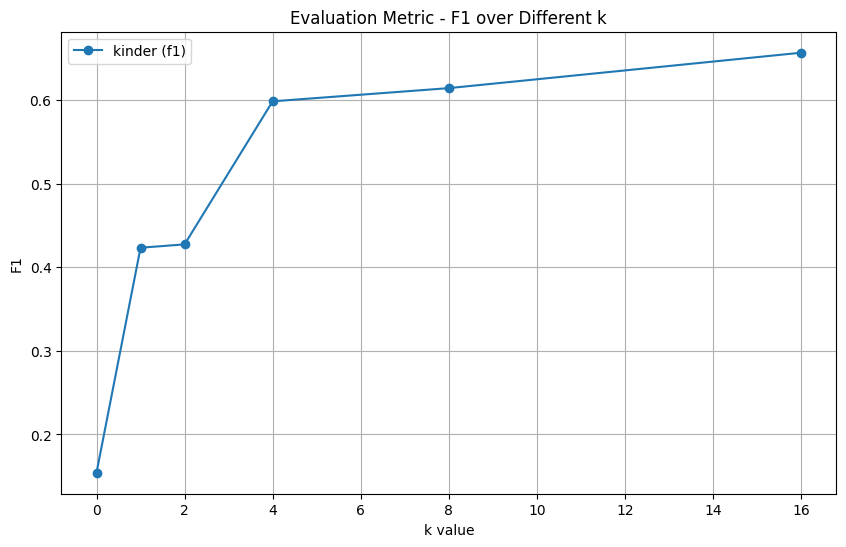

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Example data stored in defaultdict
results = eval_results

def plot_evaluation_metrics(results, metric):
    for topic, data in results.items():
        # Convert the data into a DataFrame
        df = pd.DataFrame(data).T
        df.index = df.index.astype(int)  # Ensure the index is of type integer
        df.sort_index(inplace=True)  # Sort by k values (0, 2, 8, 16)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df[metric], marker='o', label=f'{topic} ({metric})')
        plt.title(f'Evaluation Metric - {metric.capitalize()} over Different k')
        plt.xlabel('k value')
        plt.ylabel(metric.capitalize())
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the function to plot a specific metric, e.g., 'accuracy'
plot_evaluation_metrics(results, 'f1')
